# ML_9_Test_models

In [1]:
%%javascript
$('<div id="toc"></div>').css({position: 'fixed', top: '120px', left: 0}).appendTo(document.body);
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js');

<IPython.core.display.Javascript object>

## Presentation

## Setup

In [81]:
import numpy as np
import matplotlib.pyplot as plt
import os
import random
import imageio

from sklearn.model_selection import KFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
import keras_tuner as kt

from amftrack.ml.width.models import hyper_model_builder_simple, build_model_dense, build_model_conv
from amftrack.util.sys import storage_path, test_path, get_current_folders, update_plate_info
from amftrack.ml.width.data_augmentation import data_augmentation, data_preparation
from keras.utils.layer_utils import count_params  

### Fetch data

Repository with all possible datasets

In [5]:
dataset_path = os.path.join(storage_path, "datasets")

Possible datasets

In [6]:
focused_dataset_path = os.path.join(dataset_path, "focused_with_varying_lum_test") # dataset with varying lumination but consistent focus
extended_dataset_path = os.path.join(dataset_path, "varying_lum_and_focus_test") # dataset with varying lumination but consistent focus

In [10]:
def get_set(name):
    d_path = os.path.join(dataset_path, name)
    im_path = os.path.join(d_path, "slices.png")
    im = imageio.imread(im_path)
    label_path = os.path.join(d_path, "labels.npy")
    with open(label_path, 'rb') as f:
        label = np.load(f)
    label = np.expand_dims(label, axis = 1)
    
    return im, label

For now: using the focused dataset

### Visualisation

In [61]:
test_feature, test_label = get_set("focused_with_varying_lum_test")

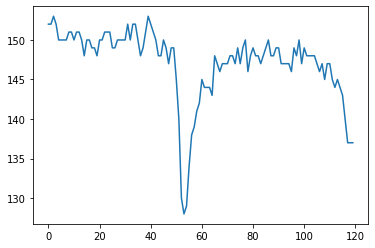

In [13]:
plt.plot(test_feature[10,:])

(array([50., 70., 45., 30.,  5.,  0., 45.,  5.,  0.,  5.]),
 array([ 2.77832604,  3.69909518,  4.61986431,  5.54063345,  6.46140258,
         7.38217172,  8.30294085,  9.22370999, 10.14447912, 11.06524826,
        11.98601739]),
 <BarContainer object of 10 artists>)

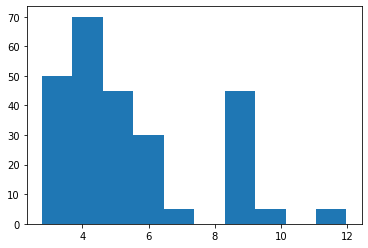

In [19]:
plt.hist(test_label)

## 1/ Mean predicting model

In [26]:
test_label.shape

(255, 1)

In [27]:
np.var(test_label)

4.976385119104691

In [29]:
np.std(test_label)

2.230781279978988

In [30]:
mean = np.mean(test_label)
pred = np.full(test_label.shape, mean)
res = np.mean((test_label - pred)**2)
print(f"Mean is: {mean}, Mean squarred error is: {res}")

Mean is: 5.407751172104067, Mean squarred error is: 4.976385119104691


In [32]:
mean = np.mean(test_label)
pred = np.full(test_label.shape, mean)
res = np.mean(abs(test_label - pred))
print(f"Mean is: {mean}, Mean absolute error is: {res}")

Mean is: 5.407751172104067, Mean absolute error is: 1.8059523605771604


## 2/ Dense model

In [36]:
def plot_against(model, test_feature, test_label):
    predicted = model.predict(test_feature)
    plt.scatter(test_label, predicted, marker='o')
    plt.plot([0,12],[0,12])
    plt.xlim(2, 16)
    plt.ylim(2, 16)

In [63]:
model = keras.models.load_model(os.path.join(storage_path, 'models', 'dense_02_focused_edge', 'saved_model_retrained.h5'))

### Score

In [59]:
model.evaluate(data_preparation(test_feature), test_label)

17/17 [==============================] - 0s 2ms/step - loss: 6.2383 - mean_absolute_error: 1.1961


[6.238253593444824, 1.1960909366607666]

### Varying illumination

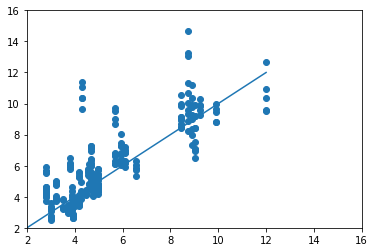

In [69]:
plot_against(model, data_preparation(test_feature), test_label)

### Variation with focus

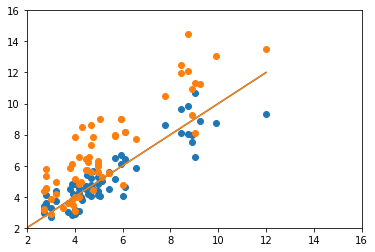

In [49]:
test_feature, test_label = get_set("single_focus_0.0_test")
plot_against(model, data_preparation(test_feature), test_label)
test_feature, test_label = get_set("single_focus_0.2_test")
plot_against(model, data_preparation(test_feature), test_label)

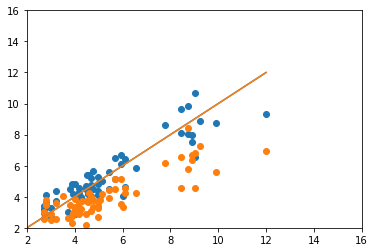

In [50]:
test_feature, test_label = get_set("single_focus_0.0_test")
plot_against(model, data_preparation(test_feature), test_label)
test_feature, test_label = get_set("single_focus_-0.2_test")
plot_against(model, data_preparation(test_feature), test_label)

### Variation with focus

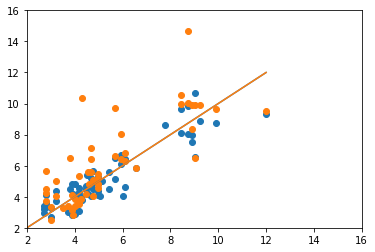

In [52]:
test_feature, test_label = get_set("single_focus_0.0_test")
plot_against(model, data_preparation(test_feature), test_label)
test_feature, test_label = get_set("single_lum_400_focus_0_test")
plot_against(model, data_preparation(test_feature), test_label)

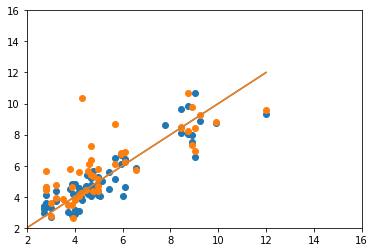

In [55]:
test_feature, test_label = get_set("single_focus_0.0_test")
plot_against(model, data_preparation(test_feature), test_label)
test_feature, test_label = get_set("single_lum_-200_focus_0_test")
plot_against(model, data_preparation(test_feature), test_label)

### General

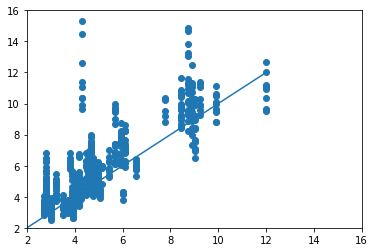

In [56]:
test_feature, test_label = get_set("varying_lum_and_focus_test")
plot_against(model, data_preparation(test_feature), test_label)

### Full plate

In [72]:
from amftrack.util.sys import storage_path
from amftrack.util.geometry import generate_index_along_sequence
from amftrack.pipeline.functions.image_processing.extract_width_fun import compute_edge_width_profile, extract_section_profiles_for_edge

In [73]:
from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
    Node,
    Edge,
)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_random_edge,
    distance_point_edge,
    plot_edge,
    plot_edge_cropped,
    find_nearest_edge,
    get_edge_from_node_labels,
    plot_full_image_with_features,
    get_all_edges,
    get_all_nodes,
    find_neighboring_edges,
    reconstruct_image,
    reconstruct_skeletton_from_edges,
    reconstruct_skeletton_unicolor,
    plot_edge_width,
)

### General parameters

In [78]:
model_name = "test"
directory = test_path
plate_name = "20220330_2357_Plate19"

### Experiment object setup

In [82]:
update_plate_info(directory)
folder_df = get_current_folders(directory)
selected_df = folder_df.loc[folder_df["folder"] == plate_name]
i = 0
exp = Experiment(directory)
exp.load(selected_df, suffix="")
exp.load_tile_information(0)

analysed:   0%|          | 0/60 [00:00<?, ?it/s]

2022-03-30 23:57:00


In [86]:
width_fun = lambda edge: compute_edge_width_profile(exp, 0, edge, resolution=4, offset=5, target_length = 100)
f = lambda n: generate_index_along_sequence(
        n, resolution=4, offset=5
    )
f_profiles = lambda edge: extract_section_profiles_for_edge(exp, 0, edge, resolution = 5, offset = 4, step = 3)

## 3/ Visualize full plate

In [87]:
edges = get_all_edges(exp, 0)
medians = {}
mean = {}
for edge in edges:
    if len(edge.pixel_list(0))>100:
        widths = width_fun(edge)
        medians[edge] = np.median(widths)

### Histogram

(array([153., 167.,  63.,  19.,   2.,   2.]),
 array([ 2.7804787,  5.0051265,  7.2297745,  9.454423 , 11.67907  ,
        13.903719 , 16.128366 ], dtype=float32),
 <BarContainer object of 6 artists>)

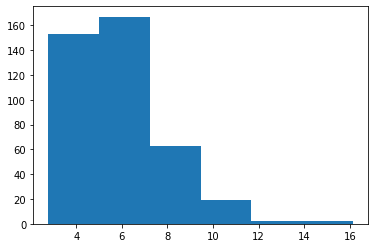

In [94]:
plt.hist(medians.values(), bins = 6)

### Full plate

In [95]:
np.min(list(medians.values()))

2.7804787

In [96]:
np.max(list(medians.values()))

16.128366

In [98]:
bins = [[0.5, 3.5], [3.5, 4.5], [4.5, 6], [6, 8], [8,12], [12, 18]]

Fonction de calcul de la width

In [99]:
def f_w(edge):
    if edge in medians:
        return medians[edge]
    else:
        return 0.

<IPython.core.display.Javascript object>


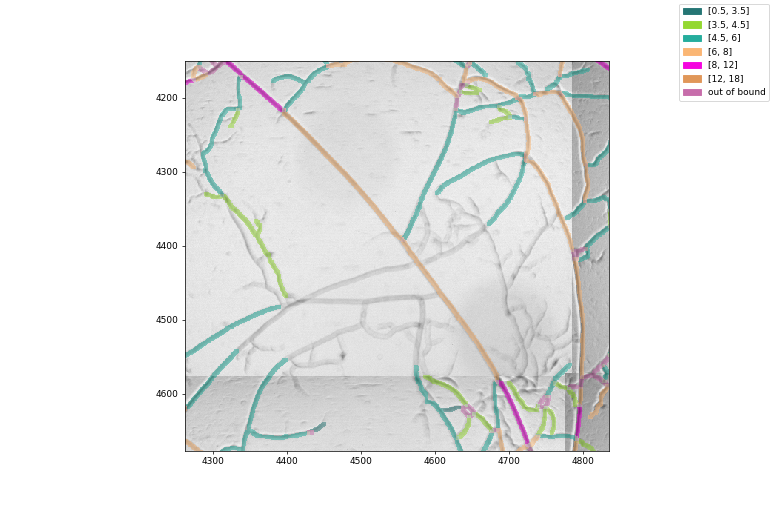

In [105]:
%matplotlib widget
plot_edge_width(exp, 0, width_fun = f_w, intervals = bins, dilation = 5, color_seed = 100)

In [ ]:
a = 1